In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing libraries

In [3]:
## HOW WE TRAINED THE MODEL



import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re


import nltk.corpus
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import tokenize


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


### If you dont have ntlk then install it!

In [12]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

# Importing data

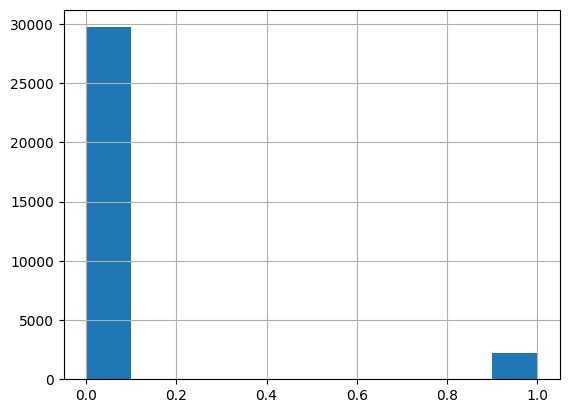

In [4]:
#LOADING DATA
train = pd.read_csv("/content/drive/My Drive/hateSpeech/train_E6oV3lV.csv")
test = pd.read_csv("/content/drive/My Drive/hateSpeech/test_tweets_anuFYb8.csv")


#PLOTTING HISTOGRAM
train['label'].hist()
plt.show()


#TURNING LABELS INTO CATEGORIES
train['label'] = train['label'].astype('category')
train.drop(columns=['id'], inplace=True)


## Our dataset is imbalanced, so just to balance it we loaded many dataset and combined the datasets so that we get a balanced data set containing nearly equal number of both the classes

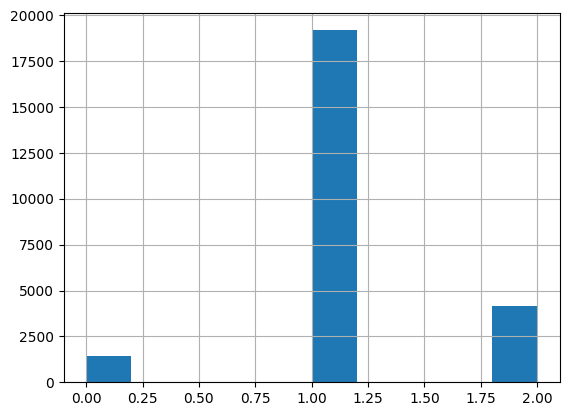

In [5]:

train_2 = pd.read_csv("/content/drive/My Drive/hateSpeech/labeled_data.csv")
train_2['class'].hist()
plt.show()

#create new columns containing
train_2['label'] = 1
# this dataset contains three levels of hate speech level 0,1,2
# We have added all hate tweets to our existing data so that we can get a balanced data



In [6]:
#Creating dataframe
train_2 = pd.DataFrame(train_2[['label',"tweet"]])

In [7]:
#Concatinating both dataframes
train = [train, train_2]
result = pd.concat(train)


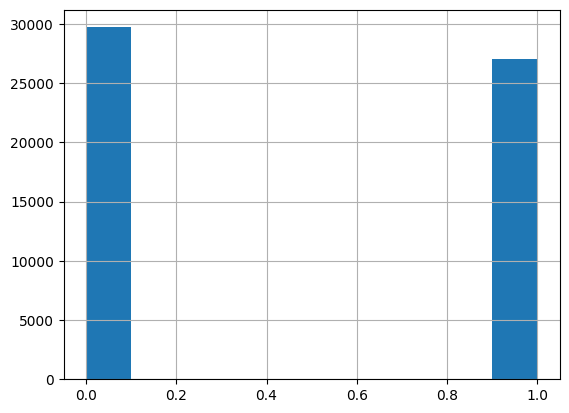

In [9]:
# shuffling data and reseting index
result=shuffle(result)
result = result.reset_index(drop=True)

#Plotting histogram
result['label'].hist()
result.to_csv('/content/drive/My Drive/hateSpeech/CombinedData.csv')

## Now we have nearly equal data of both the classes

In [10]:
#checking for null values
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   56745 non-null  int64 
 1   tweet   56745 non-null  object
dtypes: int64(1), object(1)
memory usage: 886.8+ KB




```
# This is formatted as code
```

# Preprocessing

In [13]:
# Storing stopwords of english language from nltk library
sw = set(stopwords.words("english"))

# remove stop words
def filter_words(word_list):
    useful_words = [ w for w in word_list if w not in sw ]
    return(useful_words)



def preprocess_data(dataset):
    data = dataset.copy()

    #Removing punctuations, special characters and lemmatizing words to their base form
    data['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]',' ',text)) for text in lis]) for lis in data['tweet']]

    a=[]
    for text in data['text_lem']:
        word_list = word_tokenize(text)
        text=filter_words(word_list)
        a.append(text)

    train_text = []
    for i in a:
        sent=''
        for  j in i:
            sent += str(j) + ' '
        train_text.append(sent)

    data['cleaned_tweets'] = train_text

    #Using TF-IDF vectorizer
    vect = TfidfVectorizer(ngram_range = (1,3)).fit(data['cleaned_tweets'])

    #Transforming our data using the vector trained on training data.
    vectorized_tweets = vect.transform(data['cleaned_tweets'])

    return vectorized_tweets, vect




In [14]:
#storing preprocessed data in data_train and vector in vect
data_train,vect  = preprocess_data(result)
data_target = np.array(result["label"])

In [15]:

print(data_train.shape, data_target.shape)

(56745, 702295) (56745,)


## Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_train, data_target, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45396, 702295) (45396,) (11349, 702295) (11349,)


In [17]:
# Helping_Function to show Cross Val Scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


## Training the MODEL

In [26]:
# we are using logistic regression
lg_reg_clf = LogisticRegression(C=50, penalty='l2', solver='lbfgs',max_iter=1000)

In [27]:
#Calculating cross-val score
score = cross_val_score(lg_reg_clf, X_train, y_train, cv=7, verbose=0)

# CV score:

In [28]:
#Display CV score:
display_scores(score)

Scores: [0.9582177  0.95620663 0.9612953  0.95713184 0.96021588 0.95682344
 0.96083269]
Mean: 0.958674783176569
Standard deviation: 0.0019275257650085379


## Now training model on our data and checking its accuracy on our test

In [29]:
model = lg_reg_clf.fit(X_train, y_train)

# Accuracy and confusion matrix:

Accuracy   :	 0.9650189444003877


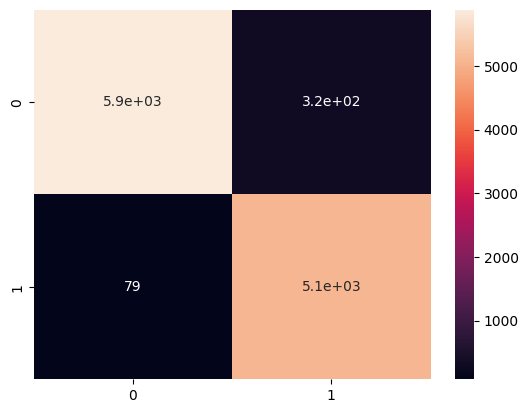

In [30]:
print("Accuracy   :\t",lg_reg_clf.score(X_test,y_test))
sns.heatmap(confusion_matrix(lg_reg_clf.predict(X_test), y_test),annot=True)
plt.show()

# Saving model and vector

In [32]:
with open('model','wb') as f:
    pickle.dump(model,f)

with open('vector','wb') as f:
    pickle.dump(vect,f)
